In [177]:
# !pip install pulp

In [178]:
import pandas as pd
import numpy as np

In [179]:
df = pd.read_csv('Nuclear waste management.csv', index_col=0)

In [180]:
df.drop([1, 5, 11, 24], inplace=True)

In [181]:
df[(df['C3'] < 0.6) & (df['C4'] < 0.6)] # best

,C1,C2,C3,C4
2,0.66,0.55,0.45,0.49
3,1.00,0.45,0.57,0.50
8,0.64,0.44,0.54,0.54


In [182]:
df[(df['C3'] > 0.65) & (df['C4'] > 0.65)] # worst

,C1,C2,C3,C4
25,0.34,1.00,1.00,1.00
26,0.71,0.25,0.88,0.67
27,0.80,0.06,1.00,0.67


In [183]:
df.sample(n=6)

,C1,C2,C3,C4
26,0.71,0.25,0.88,0.67
20,0.64,0.22,0.81,0.65
8,0.64,0.44,0.54,0.54
14,0.69,0.49,0.56,0.61
23,0.59,0.24,0.70,0.63
10,0.45,0.86,0.00,0.73


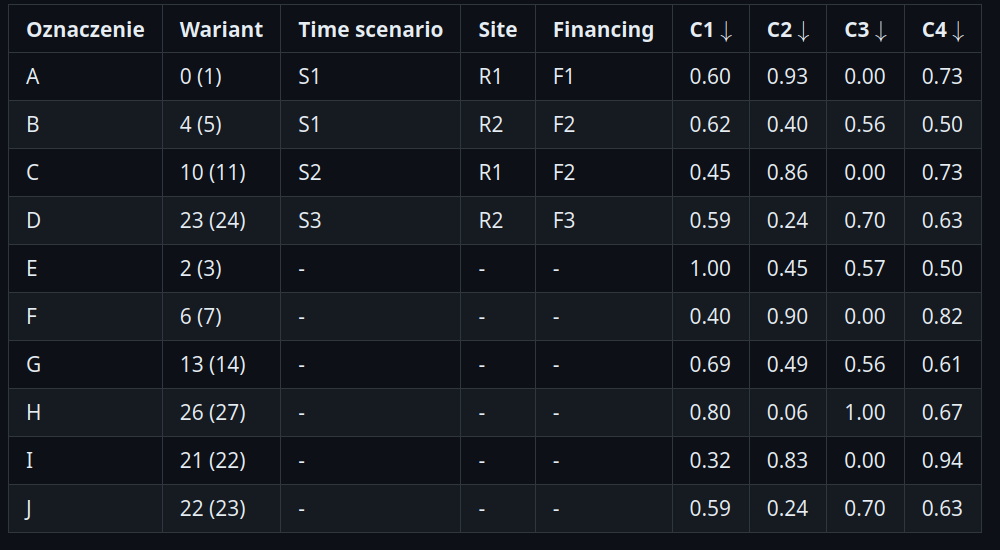


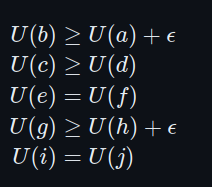

In [184]:
df = pd.read_csv('Nuclear waste management.csv', index_col=0)
reference_ranking = [0, 4, 10, 23, 2, 6, 13, 26, 21, 22]
df_rank = df.loc[df.index[reference_ranking]]
rank = np.array(df_rank)
df_rank

,C1,C2,C3,C4
1,0.60,0.93,0.00,0.73
5,0.62,0.40,0.56,0.50
11,0.61,0.54,0.38,0.49
24,0.73,0.03,1.00,0.63
3,1.00,0.45,0.57,0.50
7,0.40,0.90,0.00,0.82
14,0.69,0.49,0.56,0.61
27,0.80,0.06,1.00,0.67
22,0.32,0.83,0.00,0.94
23,0.59,0.24,0.70,0.63


In [185]:
criteria = df_rank.columns.tolist()
criteria

['C1', 'C2', 'C3', 'C4']

In [186]:
reference_alternatives = df_rank.index.tolist()
reference_alternatives

[1, 5, 11, 24, 3, 7, 14, 27, 22, 23]

In [195]:
import pulp
# disable warnings pulp
pulp.LpSolverDefault.msg = 0

problem = pulp.LpProblem("UTA_GMS", pulp.LpMaximize)

print("Kryteria:", criteria)

u_vars = {}
for alternative in reference_alternatives:
    for criterion in criteria:
        u_vars[(alternative, criterion)] = pulp.LpVariable(f"u_{alternative}_{criterion}", lowBound=0)
        print("Stworzono zmienną decyzyjną:", u_vars[(alternative, criterion)], "o dolnym ograniczeniu 0")


epsilon = pulp.LpVariable("epsilon", lowBound=0)
print("Stworzono zmienną decyzyjną:", epsilon, "o dolnym ograniczeniu 0")
problem += epsilon
print("Dodano funkcję celu:", problem.objective)


preferential_information = [(5, 1), (11, 24), (14, 27)]
indifference_information = [(3, 7), (22, 23)]

for (a, b) in preferential_information: 
    problem += pulp.lpSum(u_vars[(a, j)] for j in criteria) >= pulp.lpSum(u_vars[(b, j)] for j in criteria) + epsilon

for (a, b) in indifference_information:
    problem += pulp.lpSum(u_vars[(a, j)] for j in criteria) == pulp.lpSum(u_vars[(b, j)] for j in criteria)

print("Dodano ograniczenia preferencji i obojętności")
print("Ostateczny problem do rozwiązania:")
print(problem)

breakpoints = {}
for criterion in criteria:
    for alternative in reference_alternatives:

        breakpoints[criterion] = []

for criterion in criteria:
    for alternative in reference_alternatives:
        breakpoints[criterion].append((alternative, df_rank.loc[alternative, criterion]))

for criterion in criteria:
    breakpoints[criterion].sort(key=lambda x: x[1], reverse=True)

for criterion in criteria:
    for i in range(1, len(breakpoints[criterion])):
        key1 = (breakpoints[criterion][i-1][0], criterion)
        key2 = (breakpoints[criterion][i][0], criterion)
        problem += u_vars[key2] >= u_vars[key1]

weight = 1 / len(criteria)

for criterion in breakpoints:
        #worst
        key = (breakpoints[criterion][0][0], criterion)
        problem += u_vars[key] == 0

        #best
        key = (breakpoints[criterion][-1][0], criterion)
        problem += u_vars[key] == 1 * weight

print("Dodano ograniczenia dla punktów skrajnych")
print("Ostateczny problem do rozwiązania:")
print(problem)

problem.solve()

for v in problem.variables():
    print(v.name, "=", v.varValue)

print("Status:", pulp.LpStatus[problem.status])

Kryteria: ['C1', 'C2', 'C3', 'C4']
Stworzono zmienną decyzyjną: u_1_C1 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_1_C2 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_1_C3 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_1_C4 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_5_C1 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_5_C2 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_5_C3 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_5_C4 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_11_C1 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_11_C2 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_11_C3 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_11_C4 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_24_C1 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_24_C2 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_24_C3 o dolnym ograniczeniu 0
Stworzono zmienną decyzyjną: u_24_C4 o dolnym ograniczeniu

In [188]:
import pulp

# TODO: zaimplementować rozwiązanie problemu UTA-GMS za pomocą biblioteki PuLP
# to tylko szkielet, niekoniecznie te pętle i warunki są prawidłowo zaimplementowane

model = pulp.LpProblem("UTA_GMS_Problem", pulp.LpMaximize)

num_criteria = 4
num_variants = 10

w = 1 / num_criteria # przyjmujemy wagę 0.25 dla każdego kryterium

# non-negativity
u_best = [pulp.LpVariable(f'u_best_{i}', lowBound=0) for i in range(num_criteria)]
u_worst = [pulp.LpVariable(f'u_worst_{i}', lowBound=0, upBound=0) for i in range(num_criteria)]

epsilon = pulp.LpVariable('epsilon', lowBound=0)

u_variants = [[pulp.LpVariable(f'u_variant_{i}_{j}', lowBound=0, upBound=w) for j in range(num_criteria)] for i in range(num_variants)]

# rankingi preferencyjne

preferential_information = [(1, 0), (3, 2), (6, 7)]
indifference_information = [(4, 5), (8, 9)]

for (a, b) in preferential_information: 
    model += pulp.lpSum(u_variants[a][j] for j in range(num_criteria)) >= pulp.lpSum(u_variants[b][j] for j in range(num_criteria)) + epsilon

for (a, b) in indifference_information:
    model += pulp.lpSum(u_variants[a][j] for j in range(num_criteria)) == pulp.lpSum(u_variants[b][j] for j in range(num_criteria))
    
    
for i in range(num_criteria):
    # normalizacja
    # model += u_best[i] == 1 # zle chyba
    model += u_worst[i] == 0

    # monotoniczność
    for k in range(num_variants):
        if rank[(k+1) % num_variants,i] <= rank[k,i]:
            model += u_variants[(k+1) % num_variants][i] >= u_variants[k][i]
        else:
            model += u_variants[(k+1) % num_variants][i] >= u_variants[k][i]
                
ii, jj = np.where(arr==0)
for i,j in zip(ii,jj):
    model += u_variants[i][j] == 1 * w

ii, jj = np.where(arr==1)
for i,j in zip(ii,jj):
    model += u_variants[i][j] == 0
        
model += pulp.lpSum(u_best) == 1
model += epsilon

model.solve()

for v in model.variables():
    print(v.name, "=", v.varValue)

print("Status:", pulp.LpStatus[model.status])

NameError: name 'arr' is not defined